# Perform a Split

One of the goals of machine learning is to build a model that can generalize and perform well on new data. 
The problem is that you may not have new data, but you can simulate this experience by splitting the dataset into train, validation and test sets. 

**Training set**: A subset of the main dataset will feed into the model so that that model can learn the data patterns.

**Validation Set**: This subset helps evaluate if the model has trained optimally. It also helps to set the parameters of the model.For example:in neural networks (NN), we use the validation set to find the number of epochs for training; NN's weights etc.

**Test set**: This set checks the final model’s accuracy.

Performing a split helps the model validation process to simulate how your model perform with new data. This tutorial will cover some tools in AMPL to perform a split.





In [1]:
'''We will use the curated dataset that we created in tutorial 2 
and learn how to split it into train,validation and test sets.'''

import pandas as pd

# Set up
dataset_file = 'dataset/curated_kcna5_ic50.csv'
odir='dataset'

Machine learning (ML) models learn the relationship between molecules and molecular properties.
These models can dramatically accelerate the screening process by giving researchers information on which molecules are most and least likely to have the desired properties.

ML models, however, are only as good as the data they were trained on. In the chemical space, this problem manifests itself when a model is queried with molecules from an unfamiliar chemical space. 

# Perform a Scaffold split

Scaffolds' represent core structures of small molecules. Scaffold splits group molecules with different scaffold structures into the training, validation and test tests so that molecules with the same scaffold are grouped together in the same subset.This ensures that the train/validation/test sets are structurally different. 

A scaffold split is more challenging than a random split where the data are split into train/validation/test at random. If a model is trained on molecules that belong to only a handful of scaffold classes, its ability to predict a molecule in an unfamiliar scaffold is unknown.

In [2]:
split_type=['scaffold','random']
param_lst=[]
for split_val in split_type :
    params = {
        "verbose": "True",
        "system": "LC",

        # dataset info
        "dataset_key" : dataset_file,
        "datastore": "False",
        "response_cols" : "avg_pIC50",
        "id_col": "compound_id",
        "smiles_col" : "base_rdkit_smiles",
        "result_dir": odir,

        # splitting
        "split_only": "True",
        "previously_split": "False",
        "splitter": split_val,
        "split_valid_frac": "0.15",
        "split_test_frac": "0.15",

        # featurization & training params
        "featurizer": "ecfp",
    }
    param_lst.append(params)

The dataset split table is saved as a .csv in the same directory as the `dataset_key`. 
The name of the split file starts with the `dataset_key` and is followed by the split type (scaffold/random), 
split strategy, and the split_uuid; an unique identifier of the split.

In [3]:
from atomsci.ddm.pipeline import model_pipeline as mp
from atomsci.ddm.pipeline import parameter_parser as parse

split_lst=[]
for params in param_lst :
    pparams = parse.wrapper(params)
    MP = mp.ModelPipeline(pparams)
    split_uuid = MP.split_dataset()
    split_lst.append((params,split_uuid))

/usr/WS1/hiran/ampl160/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch_geometric'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. cannot import name 'DMPNN' from 'deepchem.models.torch_models' (/usr/WS1/hiran/ampl160/lib/python3.9/site-packages/deepchem/models/torch_models/__init__.py)
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'pytorch_lightning'
Skipped loading some Jax models, missing a dependency. jax requires jaxlib to be installed. See https://github.com/google/jax#installation for installation instructions.
INFO:ATOM:Created a dataset hash 'b7b8b0a25c13147093936f806045e0ac' from dataset_key '/usr/WS1/hiran/AMP

# Rationale between using scaffold split and random split

A generalizable model will be able to accurately predict the properties of molecules it has never seen before, 
reducing the need to perform extensive manual assays each time a new chemical class is to be tested. 
Generalizable models can predict across multiple different scaffolds and molecule types, while a non-generalizable model cannot.

A scaffold split tests model generalizability better than a random split. When using a random split, there is no guarantee that the test set will be structurally different than the training sets.

In [4]:
# display the split file location and names
import os
file_lst=[]
for params, sid in split_lst :
    fname=params['dataset_key']
    dirname=os.path.dirname(fname)
    split_val=params['splitter']

    # find the file that contains the correct uuid
    all_files = os.listdir(dirname)
    for file in all_files:
        if sid in file:
            nfile = os.path.join(dirname, file)
            file_lst.append((nfile,sid,split_val))
            break
print(file_lst)

[('dataset/curated_kcna5_ic50_train_valid_test_scaffold_bcd96299-6d61-4467-9e6b-814dcf8cde16.csv', 'bcd96299-6d61-4467-9e6b-814dcf8cde16', 'scaffold'), ('dataset/curated_kcna5_ic50_train_valid_test_random_80f0616b-b3d6-46f2-abc1-23a55ccaed99.csv', '80f0616b-b3d6-46f2-abc1-23a55ccaed99', 'random')]


# Format of the split file
The split file consits of three columns: cmpd_id is the compound id; subset tells you if the compound is in the train/validation/ test set and fold tell you which fold (Folds and split stratergies will be explained in a later tutorial)

In [5]:
# Explore contents of the split file
file,sid,split_val = file_lst[0]
df=pd.read_csv(file)
df.head(3)

,cmpd_id,subset,fold
0,CHEMBL3262827,train,0
1,CHEMBL475630,train,0
2,CHEMBL388538,train,0


### Show difference in Tanimoto distance between training and test comparison between random and scaffold split

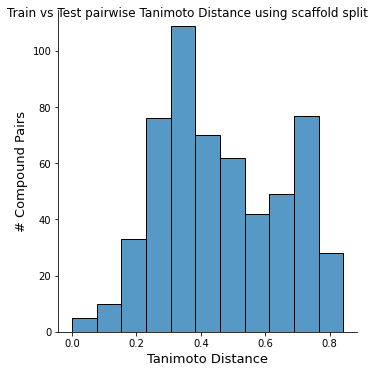

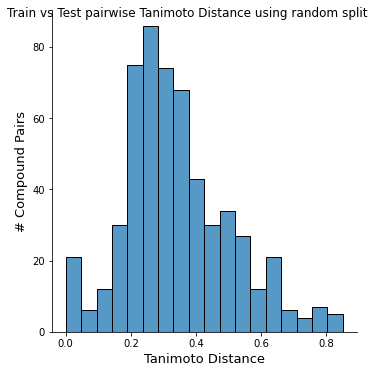

In [7]:
import atomsci.ddm.utils.compare_splits_plots as csp
from atomsci.ddm.pipeline import chem_diversity as cd

# read the dataset
df = pd.read_csv('dataset/curated_kcna5_ic50.csv')

for file, uuid, split_type in file_lst:
    # read the split file
    split = pd.read_csv(file)

    # create SplitStats
    ss = csp.SplitStats(df, split, smiles_col='base_rdkit_smiles', id_col='compound_id', response_cols=['avg_pIC50'])

    g = ss.dist_hist_train_v_test_plot()
    g.fig.suptitle(f"Train vs Test pairwise Tanimoto Distance using {split_type} split")